In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date
import random

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

C:\Users\nitin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\nitin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\nitin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\nitin\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\nitin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('./Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [5]:
data.head

<bound method NDFrame.head of                     holiday    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                           
2012-10-02 09:00:00    None  288.28      0.0      0.0          40   
2012-10-02 10:00:00    None  289.36      0.0      0.0          75   
2012-10-02 11:00:00    None  289.58      0.0      0.0          90   
2012-10-02 12:00:00    None  290.13      0.0      0.0          90   
2012-10-02 13:00:00    None  291.14      0.0      0.0          75   
...                     ...     ...      ...      ...         ...   
2018-09-30 19:00:00    None  283.45      0.0      0.0          75   
2018-09-30 20:00:00    None  282.76      0.0      0.0          90   
2018-09-30 21:00:00    None  282.73      0.0      0.0          90   
2018-09-30 22:00:00    None  282.09      0.0      0.0          90   
2018-09-30 23:00:00    None  282.12      0.0      0.0          90   

                     weather_main     weather_description               

In [6]:
ts = data['2018-05-01':'2018-09-30']

In [7]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-05-01 00:00:00,None,295.15,0.0,0.0,1,Clear,sky is clear,2018-05-01 00:00:00,576
2018-05-01 01:00:00,None,294.15,0.0,0.0,40,Clouds,scattered clouds,2018-05-01 01:00:00,395
2018-05-01 02:00:00,None,293.89,0.0,0.0,40,Clouds,scattered clouds,2018-05-01 02:00:00,275
2018-05-01 03:00:00,None,293.22,0.0,0.0,1,Clear,sky is clear,2018-05-01 03:00:00,370
2018-05-01 04:00:00,None,292.02,0.0,0.0,1,Clear,sky is clear,2018-05-01 04:00:00,916


In [8]:
ts.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,3666.000000,3666.000000,3666.0,3666.000000,3666.000000
mean,293.630262,0.116948,0.0,38.986634,3358.968085
std,5.583503,0.542208,0.0,37.284425,1956.127348
min,274.250000,0.000000,0.0,0.000000,219.000000
25%,290.302500,0.000000,0.0,1.000000,1379.250000
50%,293.920000,0.000000,0.0,40.000000,3567.500000
75%,297.440000,0.000000,0.0,75.000000,4941.000000
max,310.070000,10.600000,0.0,92.000000,7074.000000


In [9]:
split_date = '2018-08-31'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [11]:
x_train = np.array(ts_train['traffic_volume'])
x_valid = np.array(ts_test['traffic_volume'])
series = np.concatenate((x_train, x_valid), axis=0)

time_train = np.array(ts_train['ds'])
time_valid = np.array(ts_test['ds'])
time = np.concatenate((time_train, time_valid), axis=0)

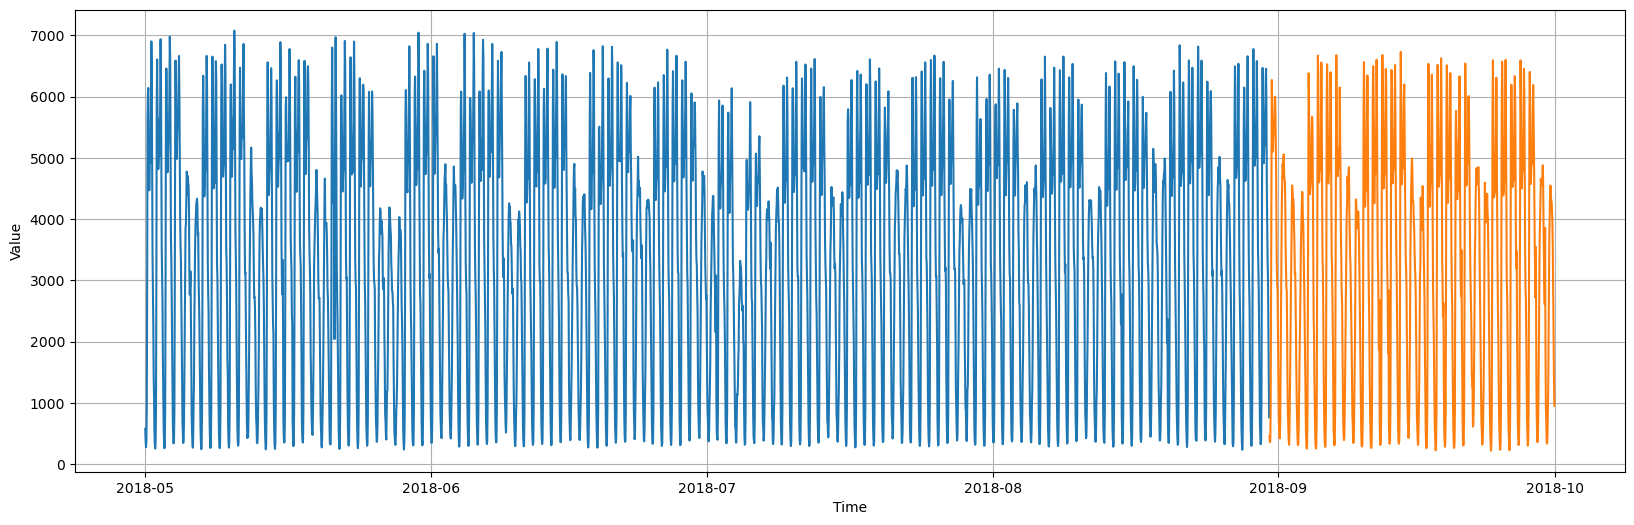

In [12]:
plt.figure(figsize=(20, 6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

In [13]:
print(len(time_train))
print(len(x_train))
print(len(time_valid))
print(len(x_valid))

2923
2923
743
743


In [14]:
window_size = 24
batch_size = 128
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.001)),
    tf.keras.layers.Lambda(lambda x: x * 10000)

])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10, restore_best_weights=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
tb = tf.keras.callbacks.TensorBoard(histogram_freq=1)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [21]:
%%time
history = model.fit(train_set,validation_data=valid_set, epochs=100, callbacks=[es, rp, tb]) 

Epoch 1/100
23/23 [==============================] - 4s 156ms/step - loss: 1427.5272 - mae: 1428.0243 - val_loss: 2181.5601 - val_mae: 2182.0569 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 52ms/step - loss: 844.2043 - mae: 844.7015 - val_loss: 1132.8921 - val_mae: 1133.3893 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 2s 58ms/step - loss: 651.1533 - mae: 651.6501 - val_loss: 967.6393 - val_mae: 968.1365 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 2s 59ms/step - loss: 541.8601 - mae: 542.3570 - val_loss: 616.2290 - val_mae: 616.7261 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 1s 55ms/step - loss: 470.6980 - mae: 471.1949 - val_loss: 596.6402 - val_mae: 597.1373 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 1s 56ms/step - loss: 412.8253 - mae: 413.3222 - val_loss: 420.5056 - val_mae: 421.0027 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 2s 61ms/step - loss: 3

In [22]:
split_time = len(time_train)
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

114/114 [==============================] - 3s 8ms/step


In [23]:
x_valid.shape

(743,)

In [24]:
rnn_forecast.shape

(743,)

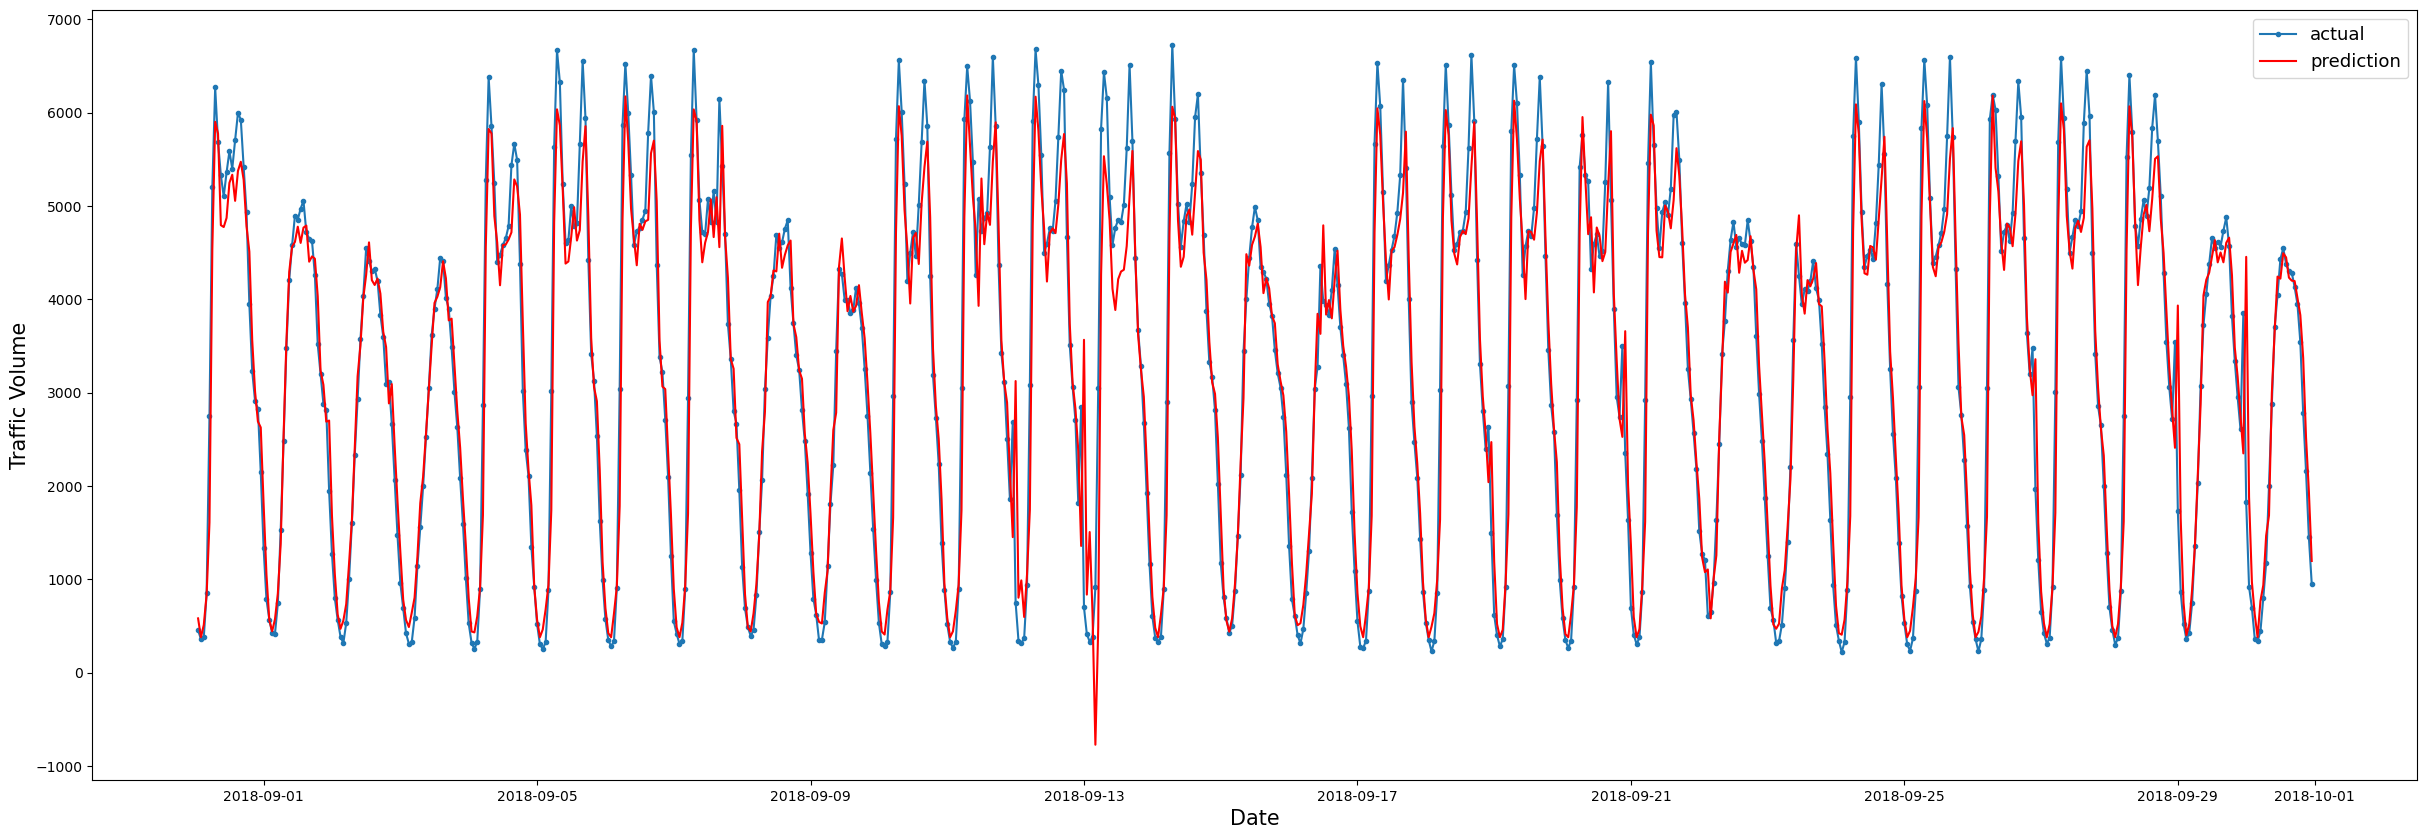

In [25]:
plt.figure(figsize=(30,10))
plt.plot(time_valid, x_valid, marker='.', label="actual")
plt.plot(time_valid, rnn_forecast, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

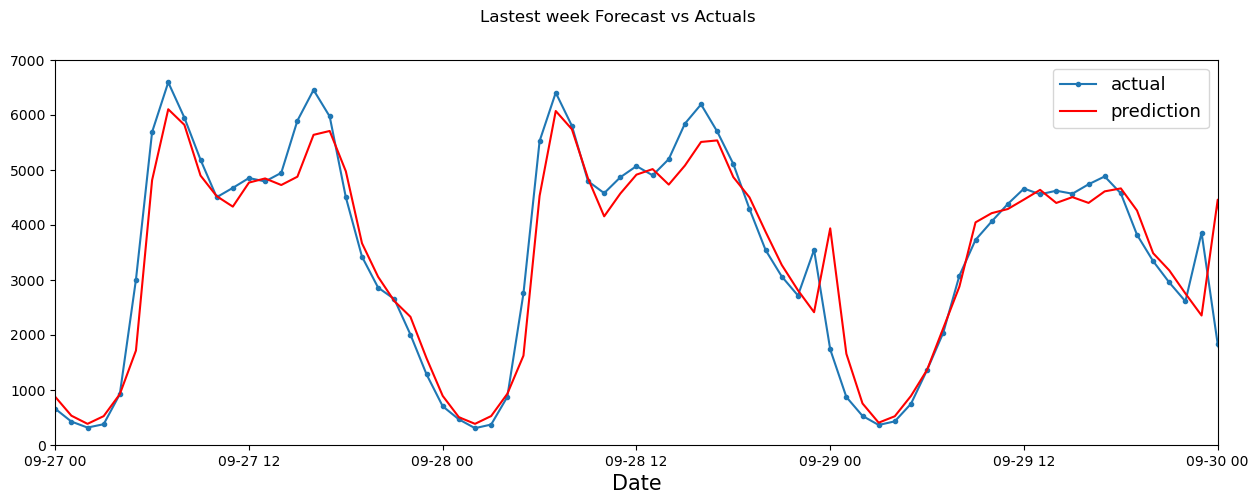

In [26]:
# zoom on lastest 3 days)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(time_valid, x_valid, marker='.', label="actual")
plt.plot(time_valid, rnn_forecast, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,30))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [27]:
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

mae = tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
mape = tf.keras.metrics.mape(x_valid, rnn_forecast).numpy()
mse = tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()
rmse = rmse(x_valid, rnn_forecast).numpy()
print(' MAE : {:.2f}'.format(mae))
print(' RMSE : {:.2f}'.format(rmse))
print(' MAPE : {:.2f} %'.format(mape))

 MAE : 344.12
 RMSE : 502.66
 MAPE : 18.47 %
